# <center>Trabajo Práctico N°1 : Reservas de Hotel</center>

**Grupo:** N°28 - The Kingdom

**Checkpoint N° 3**: Ensambles

**Alumnos**:


*   Jurgens, Cecilia Ines
*   Schipani, Martin Sebastian
*   Soto, Marylin Nicole

**Corrector:** Franco Mastelli

---


In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection  import GridSearchCV, StratifiedKFold, KFold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
ds_hotel_test = pd.read_csv("hotels_test.csv")
df_hotel_test = ds_hotel_test.copy()
ds_hotel_train = pd.read_csv("hotels_train.csv")
df_hotel_train = ds_hotel_train.copy()

## Preprocesamiento de Datasets

Analizamos la cantidad de filas y columnas entre el dataset de train y de test:

In [ ]:
print("El dataset train tiene "f"{df_hotel_train.shape[0]}"" filas y "f"{df_hotel_train.shape[1]}"" columnas.")
print("El dataset test tiene "f"{df_hotel_test.shape[0]}"" filas y "f"{df_hotel_test.shape[1]}"" columnas.")

El dataset train tiene 61913 filas y 31 columnas.
El dataset test tiene 26535 filas y 31 columnas.


Determinamos que columnas faltan en cada dataset:

In [ ]:
columnas_faltantes_train = set(df_hotel_test.columns)-set(df_hotel_train.columns)
columnas_faltantes_test = set(df_hotel_train.columns) - set(df_hotel_test.columns)

print('Columnas faltantes en el dataset de Train: ', columnas_faltantes_train)
print('Columnas faltantes en el dataset de Test: ', columnas_faltantes_test)


Columnas faltantes en el dataset de Train:  {'reservation_status_date'}
Columnas faltantes en el dataset de Test:  {'is_canceled'}


### Dataset Train:

Aplicamos la limpieza que fue detallada en el checkpoint 2 en el dataset de train:

In [ ]:
#COUNTRY
##Reemplazamos los valores nulos con la moda
df_hotel_train.fillna({'country':-1}, inplace = True)
df_hotel_train.replace({-1, "PRT"})

country_top_train = df_hotel_train['country'].value_counts()
top_20_country_train = country_top_train.head(20).index.tolist()
df_hotel_train['country'] = df_hotel_train['country'].apply(lambda x: x if x in top_20_country_train else 'other')

#LEAD_TIME
##Tratamiento de outliers:
#df_hotel_train.drop(df_hotel_train[df_hotel_train['lead_time']>=500].index, axis='index', inplace=True)

#STAYS_IN_WEEK_NIGHTS
##Tratamiento de outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['stays_in_week_nights']>=25].index, axis='index', inplace=True)

#ADULTS
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['adults']==0].index, axis='index', inplace=True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['adults']>3].index, axis='index', inplace=True)

#CHILDREN
##Eliminacion de los registros con datos nulos de esta variable:
#df_hotel_train.drop(df_hotel_train[df_hotel_train['children'].isna() == True].index, axis='index', inplace=True)
df_hotel_train.fillna({'children':0}, inplace = True)
df_hotel_train['children'] = df_hotel_train['children'].astype(int)
df_hotel_train.loc[df_hotel_train['children'] < 0, 'children'] = 0
df_hotel_train.drop(df_hotel_train[df_hotel_train['children']>=10].index, axis = 'index', inplace = True)

##Tratiento de outliers
df_hotel_train.drop(df_hotel_train[df_hotel_train['children']>=10].index, axis='index', inplace=True)

#BABIES
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['babies']>=9].index, axis='index', inplace=True)

#PREVIOUS_CANCELLATIONS
##Tratamiento de Outliers
df_hotel_train.drop(df_hotel_train[df_hotel_train['previous_cancellations']>=2].index, axis='index', inplace=True)

#DAYS_IN_WAITING_LIST
##Tratamiento de outliers
#df_hotel_train.drop(df_hotel_train[df_hotel_train['days_in_waiting_list']>=200].index, axis='index', inplace=True)

#ADR
##Tratamiento de Outliers:
df_hotel_train.drop(df_hotel_train[df_hotel_train['adr']<=0].index, axis='index', inplace=True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['adr']>=400].index, axis='index', inplace=True)
media_adr = np.mean(df_hotel_train.adr)
std_adr = np.std(df_hotel_train.adr)
df_hotel_train['z_adr'] = (df_hotel_train.adr-media_adr)/std_adr
df_hotel_train['z_adr'] = st.zscore(df_hotel_train.adr)
df_hotel_train.drop(df_hotel_train[df_hotel_train['z_adr'] > 3].index, axis = 'index', inplace = True)
df_hotel_train.drop(df_hotel_train[df_hotel_train['z_adr'] < -2].index, axis = 'index', inplace = True)
df_hotel_train.drop(labels = 'z_adr', inplace = True, axis = 1)

#REQUIRED_CAR_PARKING_SPACES
##Tratamiento de outliers:
df_hotel_train.loc[(df_hotel_train['adults'] == 2) & (df_hotel_train['required_car_parking_spaces'] == 3), 'required_car_parking_spaces'] = 2
df_hotel_train.loc[(df_hotel_train['adults'] == 2) & (df_hotel_train['required_car_parking_spaces'] == 8), 'required_car_parking_spaces'] = 2

#TOTAL_OF_SPECIAL_REQUESTS
df_hotel_train.loc[(df_hotel_train['total_of_special_requests'] >= 4), 'total_of_special_requests'] = 1

#AGENT
#df_hotel_train.dropna(subset=['agent'], inplace = True)
df_hotel_train.fillna({'agent':-1}, inplace = True)
df_hotel_train['agent'] = df_hotel_train['agent'].astype(int)

#ASSIGNED ROOM TYPE
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'K') & (df_hotel_train['adr'] >160)].index, inplace = True)
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'I') & (df_hotel_train['adr'] >210)].index, inplace = True)
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'B') & (df_hotel_train['adr'] >160)].index, inplace = True)
df_hotel_train.drop(df_hotel_train[(df_hotel_train['assigned_room_type'] == 'B') & (df_hotel_train['adr'] <30)].index, inplace = True)

df_hotel_train.drop(df_hotel_train[(df_hotel_train['distribution_channel'] == 'Undefined')].index, inplace = True)

Convertimos los meses del año en numeros:

In [ ]:
meses_a_numeros ={
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July':7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df_hotel_train.arrival_date_month = df_hotel_train.arrival_date_month.map(meses_a_numeros)

Transformamos los datos de children en int:

In [ ]:
df_hotel_train['children'] = df_hotel_train['children'].astype(int)

Reemplazamos en meal todos aquellos que dicen undefined por SC (como es aclarado en el paper):

In [ ]:
df_hotel_train.loc[df_hotel_train.loc[:,'meal'] == 'Undefined','meal'] ='SC'

Convertimos las letras de habitaciones de los hoteles por numeros:

In [ ]:
dormitorio_letra_a_numero ={
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 10,
    'L': 11
}
df_hotel_train.reserved_room_type = df_hotel_train.reserved_room_type.map(dormitorio_letra_a_numero)

Elimino todas aquellas columnas que no se necesitaran en la busqueda de arboles:

In [ ]:
columnas_eliminar =[ 'id', 'assigned_room_type', 'company']
df_hotel_train.drop(columnas_eliminar, axis='columns', inplace=True)

One hot encoding para variables categoricas:

In [ ]:
columnas_dummies = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
df_hotel_train = pd.get_dummies(df_hotel_train, columns= columnas_dummies, drop_first= True)

Verificamos que no nos queden valores nulos en el dataset train:

In [ ]:
df_hotel_train.isna().sum()

lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
agent                             0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
is_canceled                       0
hotel_Resort Hotel                0
meal_FB                           0
meal_HB                           0
meal_SC                           0
country_BEL                       0
country_BRA                       0
country_CHE                 

### Dataset Test:

Analizamos los valores nulos del dataset:

In [ ]:
df_hotel_test.isna().sum()

hotel                                 0
lead_time                             0
arrival_date_year                     0
arrival_date_month                    0
arrival_date_week_number              0
arrival_date_day_of_month             0
stays_in_weekend_nights               0
stays_in_week_nights                  0
adults                                0
children                              0
babies                                0
meal                                  0
country                              95
market_segment                        0
distribution_channel                  0
is_repeated_guest                     0
previous_cancellations                0
previous_bookings_not_canceled        0
reserved_room_type                    0
assigned_room_type                    0
booking_changes                       0
deposit_type                          0
agent                              3363
company                           25218
days_in_waiting_list                  0


In [ ]:
#COUNTRY
##Reemplazamos los valores nulos con la moda
df_hotel_test.fillna({'country':-1}, inplace = True)
df_hotel_test.replace({-1, "PRT"})

#country_top_test = df_hotel_test['country'].value_counts()
#top_5_country_test = country_top_test.head(5).index.tolist()
df_hotel_test['country'] = df_hotel_test['country'].apply(lambda x: x if x in top_20_country_train else 'other')

#AGENT
df_hotel_test.fillna({'agent':-1}, inplace = True)

#CHILDREN
df_hotel_test.fillna({'children':0}, inplace = True)
df_hotel_test['children'] = df_hotel_test['children'].astype(int)

#ADR
##Tratamiento de Outliers:
media_adr = np.mean(df_hotel_test.adr)
std_adr = np.std(df_hotel_test.adr)

#AGENT
#df_hotel_train.dropna(subset=['agent'], inplace = True)
df_hotel_train.fillna({'agent':-1}, inplace = True)
df_hotel_train['agent'] = df_hotel_train['agent'].astype(int)

df_hotel_test.loc[df_hotel_test.loc[:,'meal'] == 'Undefined','meal'] ='SC'

In [ ]:
columnas_eliminar_test = ['id', 'assigned_room_type', 'company', 'reservation_status_date' ]
df_hotel_test.drop(columnas_eliminar_test, axis='columns', inplace= True)

Convertimos los meses del año en numeros:

In [ ]:
meses_a_numeros_test ={
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July':7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}
df_hotel_test.arrival_date_month = df_hotel_test.arrival_date_month.map(meses_a_numeros_test)

Convertimos las letras de habitaciones de los hoteles por numeros:

In [ ]:
dormitorio_letra_a_numero_test ={
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'K': 10,
    'L': 11,
    'P': 12
}
df_hotel_test.reserved_room_type = df_hotel_test.reserved_room_type.map(dormitorio_letra_a_numero_test)

One hot Encoding para variables categoricas:

In [ ]:
columnas_dummies_test = ['hotel', 'meal', 'country', 'market_segment', 'distribution_channel', 'deposit_type', 'customer_type']
df_hotel_test = pd.get_dummies(df_hotel_test, columns = columnas_dummies_test, drop_first= True)

Verificamos que no nos queden valores nulos en el dataset test:

In [ ]:
df_hotel_test.isna().sum()

lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
agent                             0
days_in_waiting_list              0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
hotel_Resort Hotel                0
meal_FB                           0
meal_HB                           0
meal_SC                           0
country_BEL                       0
country_BRA                       0
country_CHE                       0
country_CHN                 

## Clasificador Support Vector Machines (SVM)

### Entrenamiento

In [ ]:
df_hotel_train_x = df_hotel_train.drop(['is_canceled'], axis = 'columns', inplace = False)
df_hotel_train_y = df_hotel_train['is_canceled'].copy()

x_train, x_test, y_train, y_test = train_test_split(df_hotel_train_x,
                                                    df_hotel_train_y,
                                                    test_size= 0.2,
                                                    random_state = 28)
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_test_minmax = min_max_scaler.transform(x_test)

stand_scaler = preprocessing.StandardScaler()
x_train_norm = stand_scaler.fit_transform(x_train)
x_test_norm = stand_scaler.transform(x_test)

### Modelo

Contrsuyo un modelo sin escalar:

              precision    recall  f1-score   support

           0       0.60      0.70      0.64      5924
           1       0.64      0.54      0.59      6002

    accuracy                           0.62     11926
   macro avg       0.62      0.62      0.62     11926
weighted avg       0.62      0.62      0.62     11926

F1 Score:  0.6151625926974739


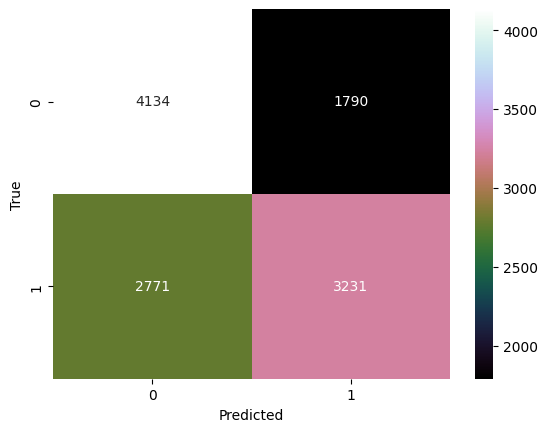

In [ ]:
svm_default = SVC()
svm_default.fit(x_train, y_train)

y_pred_train = svm_default.predict(x_test)
print(classification_report(y_test, y_pred_train))
matriz = confusion_matrix(y_test, y_pred_train)
sns.heatmap(matriz, cmap= 'cubehelix', annot = True, fmt= 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
f1 = f1_score(y_test, y_pred_train, average = 'weighted')
print("F1 Score: ", f1)

Normalizamos los datos con un escalador estandar y volvemos a entrenar el modelo:

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      5924
           1       0.84      0.83      0.84      6002

    accuracy                           0.84     11926
   macro avg       0.84      0.84      0.84     11926
weighted avg       0.84      0.84      0.84     11926

F1 Score:  0.8389240640150426


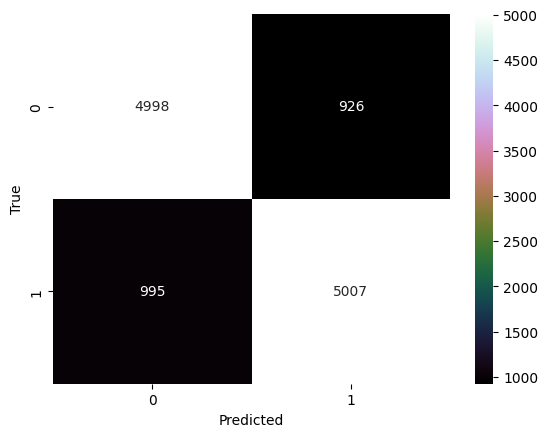

In [ ]:
svm_normalizado = SVC()
svm_normalizado.fit(x_train_norm, y_train)

y_pred_normalizado = svm_normalizado.predict(x_test_norm)
print(classification_report(y_test, y_pred_normalizado))
matriz = confusion_matrix(y_test, y_pred_normalizado)
sns.heatmap(matriz, cmap= 'cubehelix', annot = True, fmt= 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
f1 = f1_score(y_test, y_pred_normalizado, average = 'weighted')
print("F1 Score: ", f1)

              precision    recall  f1-score   support

           0       0.83      0.84      0.83      5924
           1       0.84      0.83      0.83      6002

    accuracy                           0.83     11926
   macro avg       0.83      0.83      0.83     11926
weighted avg       0.83      0.83      0.83     11926

F1 Score:  0.8343935581123125


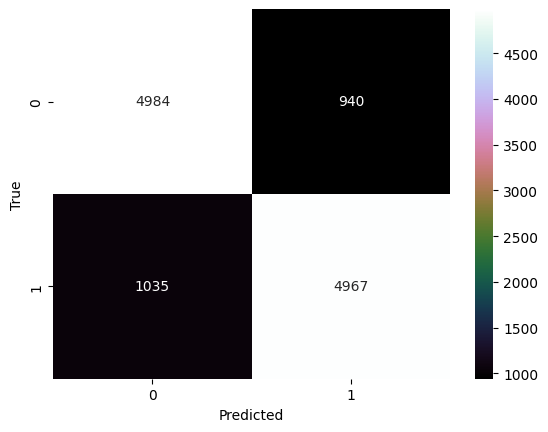

In [ ]:
svm_min_max = SVC()
svm_min_max.fit(x_train_minmax, y_train)

y_pred_min_max = svm_min_max.predict(x_test_minmax)
print(classification_report(y_test, y_pred_min_max))
matriz = confusion_matrix(y_test, y_pred_min_max)
sns.heatmap(matriz, cmap= 'cubehelix', annot = True, fmt= 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
f1 = f1_score(y_test, y_pred_min_max, average = 'weighted')
print("F1 Score: ", f1)

#### Optimizacion de Hiperparámetros

##### Kernel Linear

In [ ]:
param_grid = {'svm__C' : [0.1, 1, 5, 10],
              #'gamma': [0.01, 0.001],
              'svm__kernel': ['linear']
              }
folds = 5
kfoldcv = StratifiedKFold(n_splits = folds)
svm_model = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state = 0))])
scorer_fn = make_scorer(sk.metrics.f1_score)
grid_lineal = GridSearchCV(svm_model, param_grid, refit = True, verbose = 3, scoring = scorer_fn, cv = kfoldcv)
grid_lineal.fit(x_train_norm, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.784 total time= 1.6min
[CV 2/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.798 total time= 1.6min
[CV 3/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.795 total time= 1.8min
[CV 4/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.784 total time= 2.1min
[CV 5/5] END ....svm__C=0.1, svm__kernel=linear;, score=0.798 total time= 2.8min
[CV 1/5] END ......svm__C=1, svm__kernel=linear;, score=0.784 total time= 4.6min
[CV 2/5] END ......svm__C=1, svm__kernel=linear;, score=0.799 total time= 4.6min
[CV 3/5] END ......svm__C=1, svm__kernel=linear;, score=0.796 total time= 5.9min
[CV 4/5] END ......svm__C=1, svm__kernel=linear;, score=0.784 total time= 6.1min
[CV 5/5] END ......svm__C=1, svm__kernel=linear;, score=0.797 total time= 5.4min
[CV 1/5] END ......svm__C=5, svm__kernel=linear;, score=0.784 total time=17.1min
[CV 2/5] END ......svm__C=5, svm__kernel=linear;,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=0))]),
             param_grid={'svm__C': [0.1, 1, 5, 10], 'svm__kernel': ['linear']},
             scoring=make_scorer(f1_score), verbose=3)

In [ ]:
print(f"Mejores hiperparametros del SVM con kernel lineal: {grid_lineal.best_params_}")

print(f"Mejor F1 Score: {grid_lineal.best_score_}")

Mejores hiperparametros del SVM con kernel lineal: {'svm__C': 10, 'svm__kernel': 'linear'}
Mejor F1 Score: 0.7923262526644475

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      5924
           1       0.81      0.78      0.79      6002

    accuracy                           0.80     11926
   macro avg       0.80      0.80      0.80     11926
weighted avg       0.80      0.80      0.80     11926

F1 Score:  0.7975877875372805


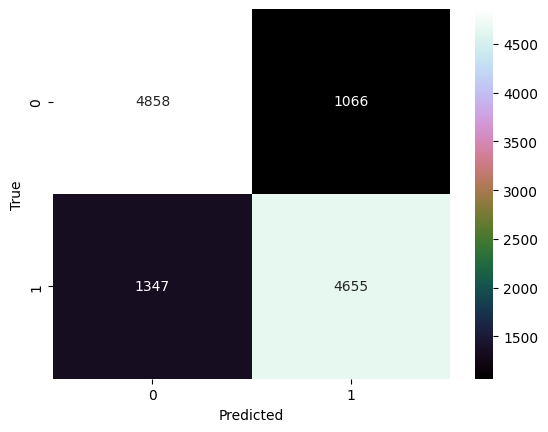

In [ ]:
clf_linear = SVC(kernel= 'linear', C=10)
clf_linear.fit(x_train_norm, y_train)
y_pred_linear = clf_linear.predict(x_test_norm)
print(classification_report(y_test, y_pred_linear))
matriz = confusion_matrix(y_test, y_pred_linear)
sns.heatmap(matriz, cmap= 'cubehelix', annot = True, fmt= 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
f1_linear = f1_score(y_test, y_pred_linear, average = 'weighted')
print("F1 Score: ", f1_linear)

###### Exportamos el modelo

In [ ]:
#f1_train = f1_score(y_test, y_pred_linear, average= 'weighted')
#params_lineal = clf_linear.get_params()
#kernel = params_lineal['svm__kernel']
#C = params_lineal['svm__C']
joblib.dump(clf_linear, 'svm_lineal.joblib')

['svm_lineal.joblib']

In [ ]:
y_pred_svm_lin = clf_linear.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred_svm_lin})

In [ ]:
df_summision.to_csv('summit_svm_lineal.csv', index = False)

##### Kernel Radial

Buscamos los mejores hiperparametros:

In [ ]:
param_grid = {'svm__C' : [1, 10, 50],
              'svm__gamma': [0.1, 0.01, 0.001],
              'svm__kernel': ['rbf']
              }
folds = 4
kfoldcv = StratifiedKFold(n_splits = folds)
svm_model = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state = 0))])
scorer_fn = make_scorer(sk.metrics.f1_score)
grid_radial = GridSearchCV(svm_model, param_grid, refit = True, verbose = 3, scoring = scorer_fn, cv = kfoldcv)
grid_radial.fit(x_train_norm, y_train)

Fitting 4 folds for each of 9 candidates, totalling 36 fits
[CV 1/4] END svm__C=1, svm__gamma=0.1, svm__kernel=rbf;, score=0.834 total time= 4.0min
[CV 2/4] END svm__C=1, svm__gamma=0.1, svm__kernel=rbf;, score=0.845 total time= 3.8min
[CV 3/4] END svm__C=1, svm__gamma=0.1, svm__kernel=rbf;, score=0.830 total time= 3.8min
[CV 4/4] END svm__C=1, svm__gamma=0.1, svm__kernel=rbf;, score=0.830 total time= 3.7min
[CV 1/4] END svm__C=1, svm__gamma=0.01, svm__kernel=rbf;, score=0.822 total time= 1.4min
[CV 2/4] END svm__C=1, svm__gamma=0.01, svm__kernel=rbf;, score=0.836 total time= 1.5min
[CV 3/4] END svm__C=1, svm__gamma=0.01, svm__kernel=rbf;, score=0.824 total time= 1.4min
[CV 4/4] END svm__C=1, svm__gamma=0.01, svm__kernel=rbf;, score=0.829 total time= 1.5min
[CV 1/4] END svm__C=1, svm__gamma=0.001, svm__kernel=rbf;, score=0.792 total time= 1.6min
[CV 2/4] END svm__C=1, svm__gamma=0.001, svm__kernel=rbf;, score=0.802 total time= 1.6min
[CV 3/4] END svm__C=1, svm__gamma=0.001, svm__kernel

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=0))]),
             param_grid={'svm__C': [1, 10, 50],
                         'svm__gamma': [0.1, 0.01, 0.001],
                         'svm__kernel': ['rbf']},
             scoring=make_scorer(f1_score), verbose=3)

In [ ]:
print(f"Mejores hiperparametros del SVM con kernel radial: {grid_radial.best_params_}")

print(f"Mejor F1 Score: {grid_radial.best_score_}")

Mejores hiperparametros del SVM con kernel radial: {'svm__C': 50, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Mejor F1 Score: 0.8419721031645203


              precision    recall  f1-score   support

           0       0.85      0.84      0.84      5924
           1       0.84      0.85      0.85      6002

    accuracy                           0.84     11926
   macro avg       0.84      0.84      0.84     11926
weighted avg       0.84      0.84      0.84     11926

F1 Score:  0.8448708846483429


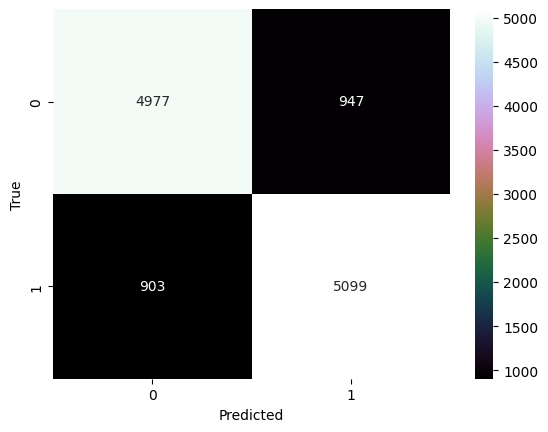

In [ ]:
clf_radial = SVC(kernel= 'rbf', C=50, gamma = 0.01)
clf_radial.fit(x_train_norm, y_train)
y_pred_radial = clf_radial.predict(x_test_norm)
print(classification_report(y_test, y_pred_radial))
matriz = confusion_matrix(y_test, y_pred_radial)
sns.heatmap(matriz, cmap= 'cubehelix', annot = True, fmt= 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
f1_radial = f1_score(y_test, y_pred_radial, average = 'weighted')
print("F1 Score: ", f1_radial)

In [ ]:
#params_radial = clf_radial.get_params()
#kernel_radial = params_radial['svm__kernel']
#C_radial = params_radial['svm__C']
#gamma_radial = params_radial['svm__gamma']

joblib.dump(clf_radial, 'svm_radial.joblib')

['svm_radial.joblib']

In [ ]:
y_pred_svm_radial = clf_radial.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred_svm_radial})

In [ ]:
df_summision.to_csv('summit_svm_radial.csv', index = False)

#### SVM con kernel Polinomico

In [ ]:
param_grid = {'svm__C' : [1, 10],
              'svm__gamma': [0.1, 0.01],
              'svm__degree': [3],
              'svm__coef0': [0, 0.5, 1],
              'svm__kernel': ['poly']
              }
folds = 2
kfoldcv = StratifiedKFold(n_splits = folds)
svm_model = Pipeline([('scaler', StandardScaler()), ('svm', SVC(random_state = 0))])
scorer_fn = make_scorer(sk.metrics.f1_score)
grid_poly = GridSearchCV(svm_model, param_grid, refit = True, verbose = 3, scoring = scorer_fn, cv = kfoldcv)
grid_poly.fit(x_train_norm, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2] END svm__C=1, svm__coef0=0, svm__degree=3, svm__gamma=0.1, svm__kernel=poly;, score=0.823 total time= 4.9min
[CV 2/2] END svm__C=1, svm__coef0=0, svm__degree=3, svm__gamma=0.1, svm__kernel=poly;, score=0.821 total time= 4.8min
[CV 1/2] END svm__C=1, svm__coef0=0, svm__degree=3, svm__gamma=0.01, svm__kernel=poly;, score=0.805 total time=  45.6s
[CV 2/2] END svm__C=1, svm__coef0=0, svm__degree=3, svm__gamma=0.01, svm__kernel=poly;, score=0.806 total time=  44.2s
[CV 1/2] END svm__C=1, svm__coef0=0.5, svm__degree=3, svm__gamma=0.1, svm__kernel=poly;, score=0.826 total time= 5.1min
[CV 2/2] END svm__C=1, svm__coef0=0.5, svm__degree=3, svm__gamma=0.1, svm__kernel=poly;, score=0.823 total time= 5.0min
[CV 1/2] END svm__C=1, svm__coef0=0.5, svm__degree=3, svm__gamma=0.01, svm__kernel=poly;, score=0.828 total time=  32.8s
[CV 2/2] END svm__C=1, svm__coef0=0.5, svm__degree=3, svm__gamma=0.01, svm__kernel=poly;, score=0.827 to

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC(random_state=0))]),
             param_grid={'svm__C': [1, 10], 'svm__coef0': [0, 0.5, 1],
                         'svm__degree': [3], 'svm__gamma': [0.1, 0.01],
                         'svm__kernel': ['poly']},
             scoring=make_scorer(f1_score), verbose=3)

In [ ]:
print(f"Mejores hiperparametros del SVM con kernel polinomica: {grid_poly.best_params_}")

print(f"Mejor F1 Score: {grid_poly.best_score_}")

Mejores hiperparametros del SVM con kernel polinomica: {'svm__C': 10, 'svm__coef0': 0.5, 'svm__degree': 3, 'svm__gamma': 0.01, 'svm__kernel': 'poly'}
Mejor F1 Score: 0.8329327943298532


              precision    recall  f1-score   support

           0       0.84      0.84      0.84      5924
           1       0.84      0.85      0.84      6002

    accuracy                           0.84     11926
   macro avg       0.84      0.84      0.84     11926
weighted avg       0.84      0.84      0.84     11926

F1 Score:  0.8433647364026327


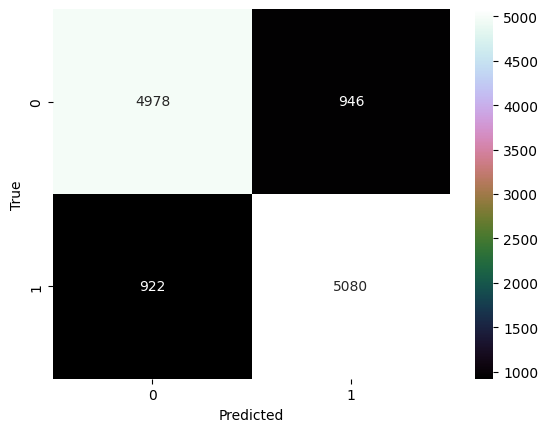

In [ ]:
clf_poly = SVC(kernel= 'poly', C=10 , coef0= 0.5, degree = 3, gamma = 0.01)
clf_poly.fit(x_train_norm, y_train)
y_pred_poly = clf_poly.predict(x_test_norm)
print(classification_report(y_test, y_pred_poly))
matriz = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(matriz, cmap= 'cubehelix', annot = True, fmt= 'g')
plt.xlabel('Predicted')
plt.ylabel('True')
f1_poly = f1_score(y_test, y_pred_poly, average = 'weighted')
print("F1 Score: ", f1_poly)

In [ ]:
joblib.dump(clf_poly, 'svm_poly.joblib')

['svm_poly.joblib']

In [ ]:
y_pred_svm_poly = clf_poly.predict(df_hotel_test)
df_summision = pd.DataFrame({'id': ds_hotel_test['id'], 'is_canceled': y_pred_svm_poly})

In [ ]:
df_summision.to_csv('summit_svm_poly.csv', index = False)